# NWA suntans: play with snapshot

see [description](https://github.com/TIDE-ITRH/tide-suntans-nws) and relevant paper: [Rayson et al. 2021](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JC017570)

In [1]:
import os

import numpy as np
#import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:37305' processes=8 threads=56, memory=100.00 GiB>

---
## load data

In [3]:
ds, grd = nwa.load_surf()

# temporal zoom
ds = ds.isel(time=slice(0,5)).persist()

---

## plotting

In [4]:
da = ds.eta.isel(time=1).persist()

In [5]:
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu')

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


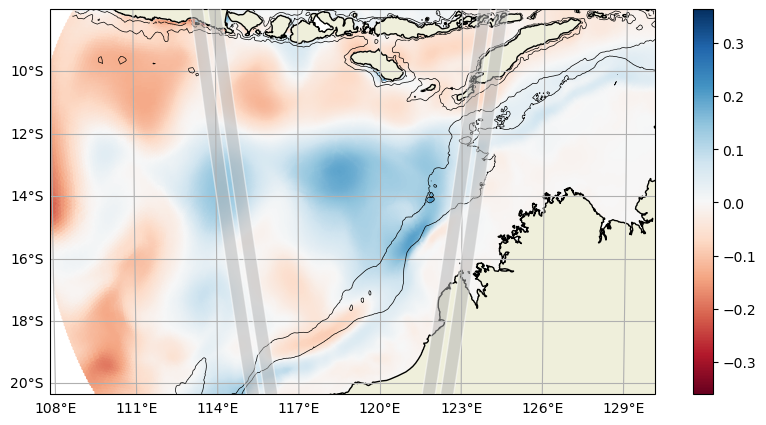

In [6]:
fig, ax = nwa.map_init("large", bathy=(grd, ds))
_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu', crs=crs)

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


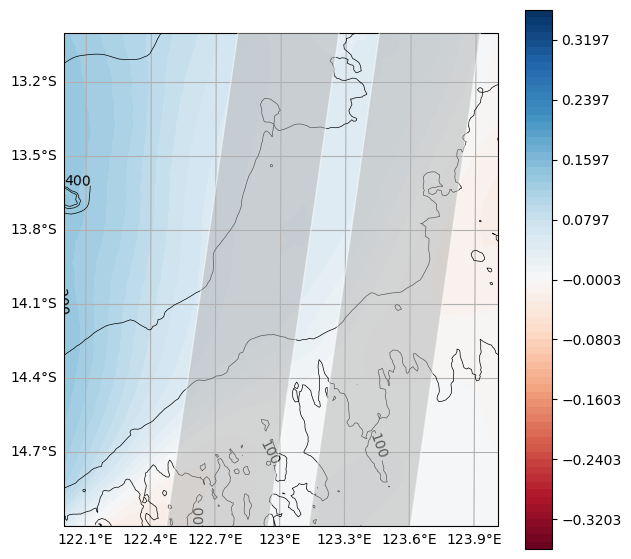

In [5]:
zoom= "cp"

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))

#_, _, poly, cbar = grd.suntans.plotcelldata(da, cmap='RdBu', transform=crs)

vmin, vmax = float(da.min()), float(da.max())
#lvls = np.arange(-1,1,.1)
lvls = np.arange(vmin,vmax,.01)
_, _, tri, cbar = grd.suntans.contourf(da, clevs=lvls, cmap="RdBu", transform=crs)

---

## temperature & vorticity

In [3]:
start, end = "2013/09/02 00:00", "2013/09/04 00:00"
#start, end = "2014/01/15 00:00", "2014/01/16 00:00"
di = 6

#start, end, di = None, None, 24*30

In [4]:
def load_data(low=False):
    
    ds, grd = nwa.load_surf()
    zarr_grad = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_gradients")
    
    if low:
        zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
        ds = xr.open_zarr(zarr)
        zarr_grad = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_gradients")

    if start is not None and end is not None:
        ds = ds.sel(time=slice(start, end))
    ds = ds.isel(time=slice(0, None, di))

    # add deformations
    dsd = xr.open_zarr(zarr_grad)

    if start is not None and end is not None:
        dsd = dsd.sel(time=slice(start, end))
    dsd = dsd.isel(time=slice(0, None, di))

    f = pin.geo.coriolis(ds.yv)
    ds["vorticity"] = (dsd["dvcdx"] - dsd["ducdy"])/f
    ds["divergence"] = (dsd["ducdx"] + dsd["dvcdy"])/f
    ds["grad_temp"] = np.sqrt(dsd["dtempdx"]**2 + dsd["dtempdy"]**2)

    #dsd["strain_normal"] = dsd["ducdx"] - dsd["dvcdy"]
    #dsd["strain_shear"] = dsd["dvcdx"] + dsd["ducdy"]
    
    ds = ds.persist()
    
    return ds, grd

In [5]:
ds, grd = load_data()
ds_low, _ = load_data(low=True)

In [7]:
# load model moorings
moorings = nwa.load_moorings()[["lonv", "latv"]]
#moorings = nwa.zoom(moorings, nwa.bounds["large"], x="lonv", y="latv")

### single snapshot

In [8]:
it = 4
#it = 0 # "2014/01/15 00:00", "2014/01/16 00:00"
_ds = ds.isel(time=it)
_ds_low = ds_low.isel(time=it)
t = str(_ds.time.dt.strftime("%Y/%m/%d %H").values)

In [7]:
# interpolate velocities
zoom = "large"
dx = 5e3
dsuv = nwa.interpolate_hvelocities(_ds, grd, zoom, dx=dx)
dsuv_low = nwa.interpolate_hvelocities(_ds_low, grd, zoom, dx=dx)


Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Text(0.5, 1.0, 'vorticity - 2014/01/15 00')

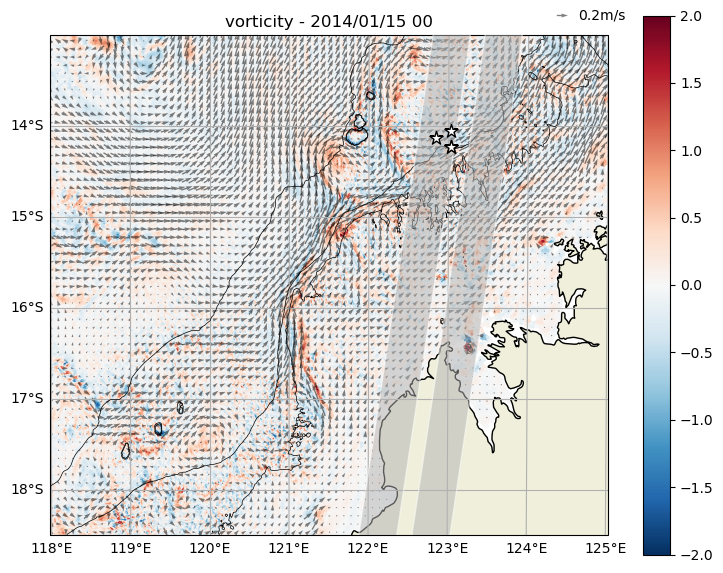

In [12]:
fig, ax = nwa.map_init("central", bathy=(grd, ds))

nwa.plot_moorings(ax)
_, _, poly, cbar = grd.suntans.plotcelldata(_ds_low.vorticity, vmin=-2., vmax=2., cmap='RdBu_r', crs=crs)

nwa.plot_velocity(ax, dsuv_low, di=2, alpha=.5, uref=.2, xref=.7, yref=.88)

ax.set_title(f"vorticity - {t}")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

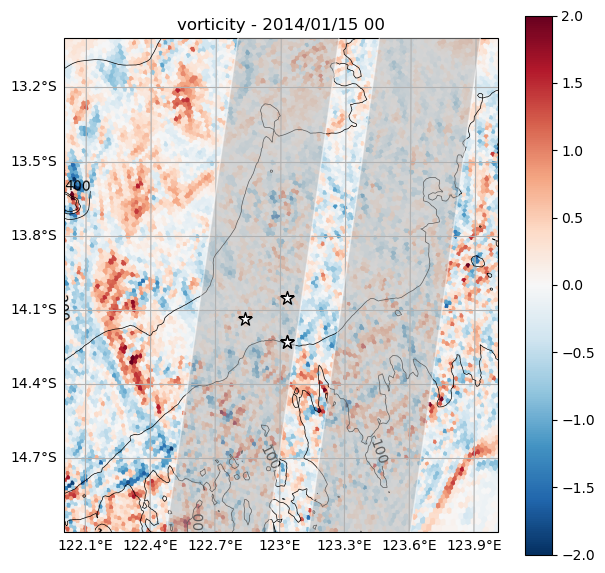

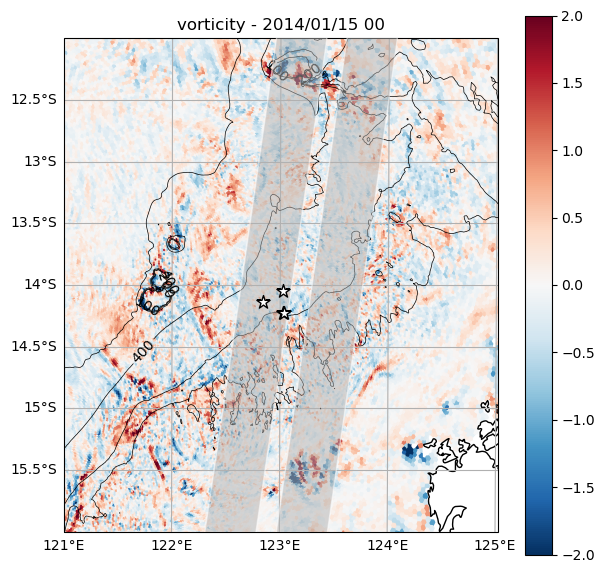

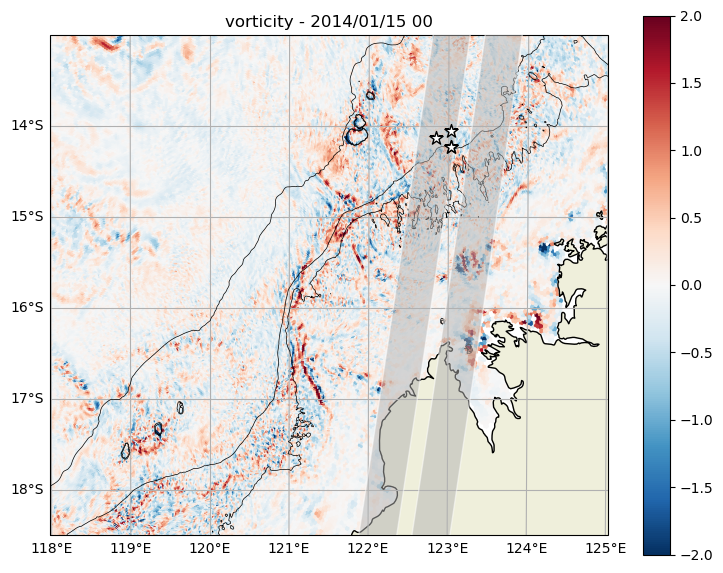

In [9]:
for zoom in ["cp", "cp_large", "central"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(_ds.vorticity, vmin=-2., vmax=2., cmap='RdBu_r', crs=crs)
    #nwa.plot_velocity(ax, dsuv_low, di=1, alpha=.5)    
    ax.set_title(f"vorticity - {t}")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

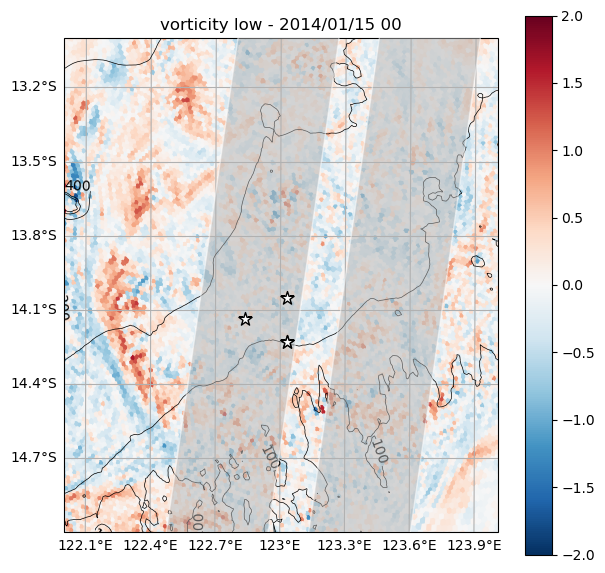

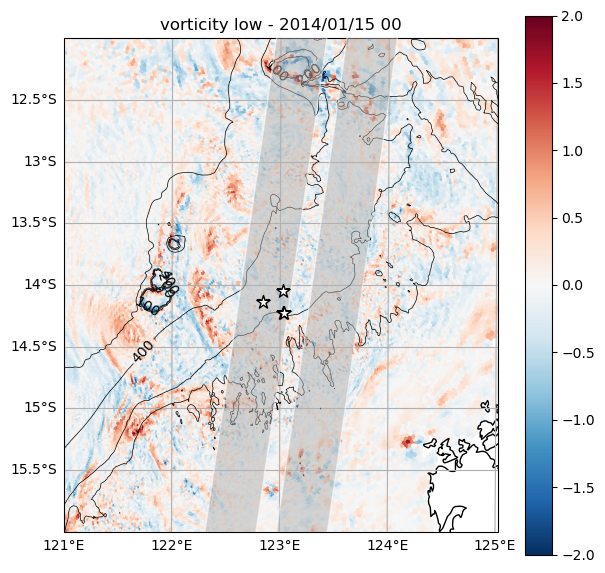

In [10]:
for zoom in ["cp", "cp_large", "central"]:
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
    nwa.plot_moorings(ax)
    _, _, poly, cbar = grd.suntans.plotcelldata(_ds_low.vorticity, vmin=-2., vmax=2., cmap='RdBu_r', crs=crs)
    #nwa.plot_velocity(ax, dsuv_low, di=1, alpha=.5)
    ax.set_title(f"vorticity low - {t}")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


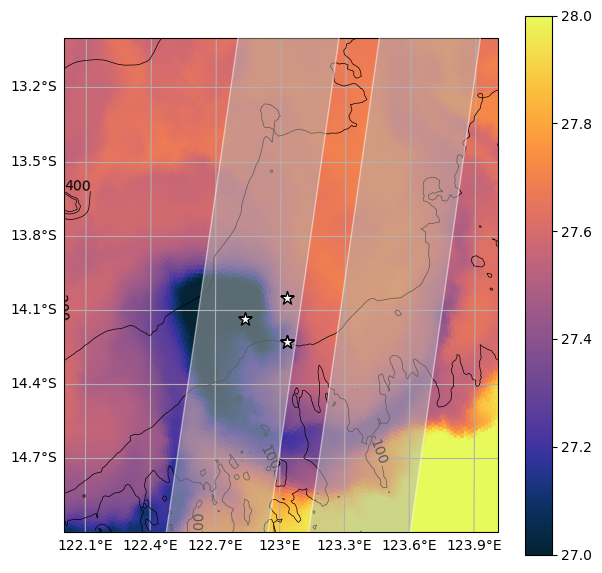

In [10]:
fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
nwa.plot_moorings(ax)
_, _, poly, cbar = grd.suntans.plotcelldata(_ds.temp, vmin=27, vmax=28, cmap=pin.thermal, crs=crs)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


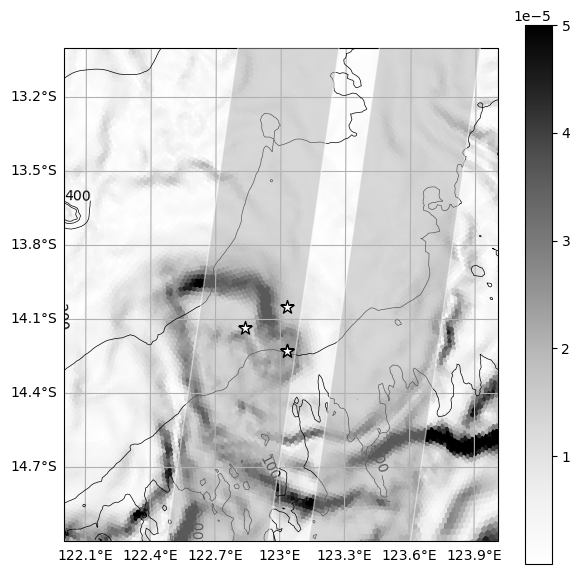

In [11]:
fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
nwa.plot_moorings(ax)
_, _, poly, cbar = grd.suntans.plotcelldata(_ds.grad_temp, vmax=5e-5, cmap="Greys", crs=crs)

In [12]:
_ds = nwa.zoom(ds, nwa.area_cp_large).compute()

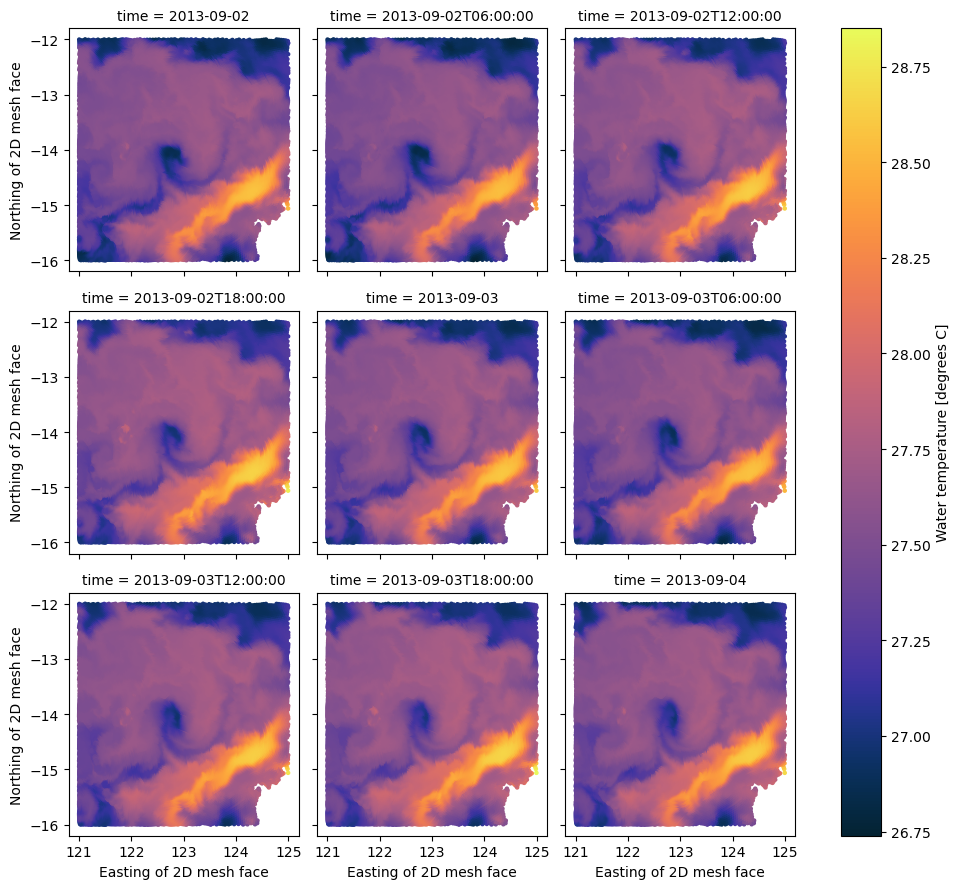

In [15]:
xr.plot.scatter(_ds, "xv", "yv", s=5, hue="temp", vmin=27, vmax=28, col="time", col_wrap=3, cmap=pin.thermal)

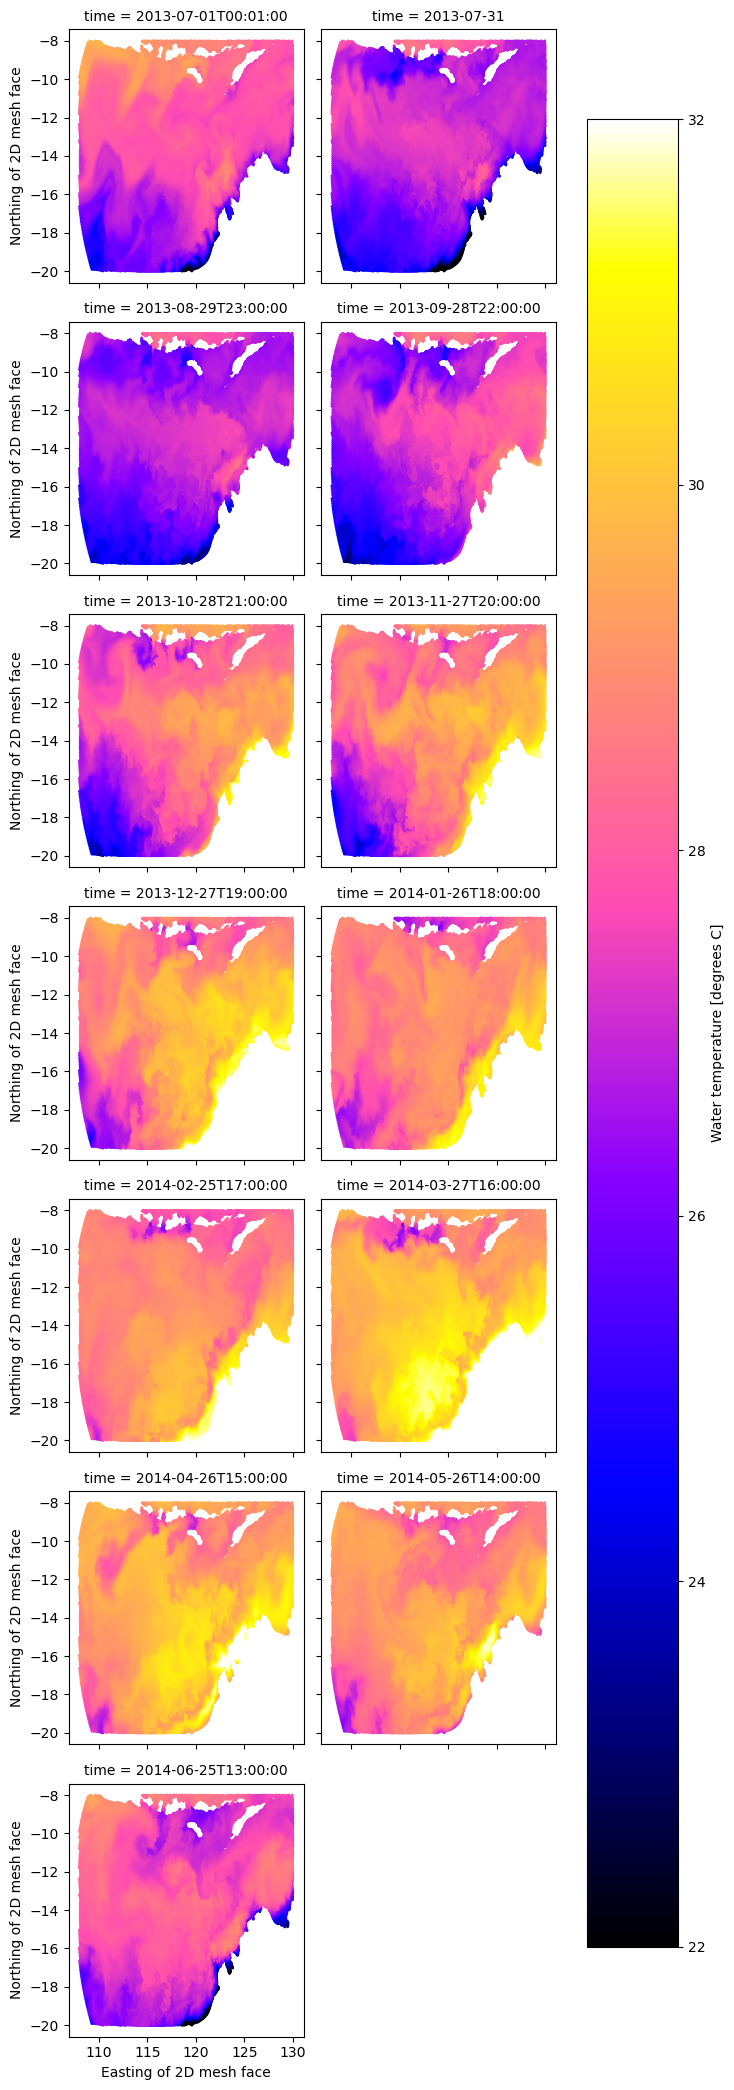

In [25]:
_ds = nwa.zoom(ds, nwa.area_large).compute()
xr.plot.scatter(_ds, "xv", "yv", s=1,
                vmin=22, vmax=32,
                hue="temp", cmap="gnuplot2", # pin.thermal
                col="time", col_wrap=2)
#vmin=27, vmax=28, 


---

## quivers

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Text(0.5, 1.0, 'vorticity - 2013/09/03 00')

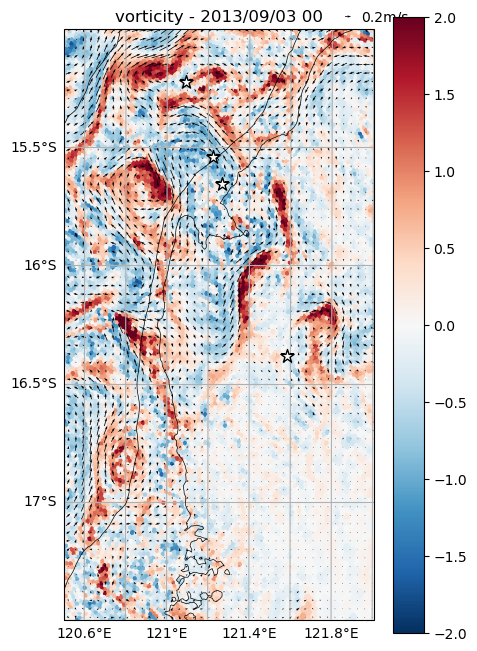

In [9]:
# interpolate velocities
zoom = "ridge"
dx = 1e3
dsuv = nwa.interpolate_hvelocities(_ds, grd, zoom, dx=dx)
dsuv_low = nwa.interpolate_hvelocities(_ds_low, grd, zoom, dx=dx)
_moorings = nwa.zoom(moorings, nwa.bounds[zoom], x="lonv", y="latv")

#
fig, ax = nwa.map_init(zoom, bathy=(grd, ds))
# extent=(120.5, 122, -17.5, -15), figsize=(5,8)

nwa.plot_moorings(ax, moorings=_moorings)
_, _, poly, cbar = grd.suntans.plotcelldata(_ds_low.vorticity, vmin=-2., vmax=2., cmap='RdBu_r', crs=crs)

nwa.plot_velocity(ax, dsuv_low, di=4, uref=.2, xref=.7, yref=.88)

ax.set_title(f"vorticity - {t}")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Text(0.5, 1.0, 'vorticity - 2013/09/03 00')

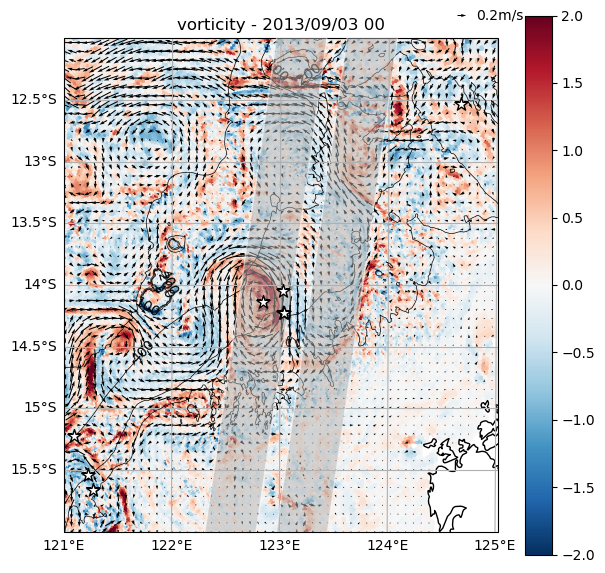

In [11]:
# interpolate velocities
zoom = "cp_large"

dx = 2e3
dsuv = nwa.interpolate_hvelocities(_ds, grd, zoom, dx=dx)
dsuv_low = nwa.interpolate_hvelocities(_ds_low, grd, zoom, dx=dx)
_moorings = nwa.zoom(moorings, nwa.bounds[zoom], x="lonv", y="latv")

#
#extent=(120.5, 122, -17.5, -15), figsize=(5,8)
fig, ax = nwa.map_init(zoom, bathy=(grd, ds))

nwa.plot_moorings(ax, moorings=_moorings)
_, _, poly, cbar = grd.suntans.plotcelldata(_ds_low.vorticity, vmin=-2., vmax=2., cmap='RdBu_r', crs=crs)

nwa.plot_velocity(ax, dsuv_low, di=4, uref=.2, xref=.7, yref=.88)

ax.set_title(f"vorticity - {t}")

---

In [41]:
cluster.close()